In [178]:
# Two-state Hidden Markov model to identify polypyrimidine tracts upstream of 3' splice sites.

from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [179]:
# Train-test split of intronic sequences.
# Pull the sequences you want to train and test on.

DataBase = '/Users/nrk/Desktop/PhD/Database/SpliceSites/'

# 172k
with open(DataBase + 'train3_true.txt') as f: positive_train = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 3.4m. A random subset of this will go into the test set, too large.
with open(DataBase + 'train3_null.txt') as f: negative_train = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 12k
with open(DataBase + 'test3_true.txt') as f: positive_test = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 240k
with open(DataBase + 'test3_null.txt') as f: negative_test = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
    

In [222]:
# Two-state Hidden Markov model (HMM). States are Purine and Polpyrimidine tract.
# Input: Sequences to train the model and HMM probabilities
# Output: Each sequence's state path and the HMM model itself

# Terminology: A_trans for transition probabilities, B_emit for emission probabilties, and pi_initial for initial probabilities.
# HMMlearn documentation: https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_multinomial_hmm.html
# Sklearn to one-hot encode sequences

def two_state_model(sequences, pi_initial, B_emit, A_trans):

    # R stands for purine sequence. Y stands for pyrimidine tract.
    states = ["R", "Y"]
    id2topic = dict(enumerate(states))
    
    vocabulary = ["A", "C", "G", "T"]
    
    observations = [base for seq in sequences for base in seq]
    
    # One-hot encode bases
    
    vocab2id = dict(enumerate(vocabulary))

    # Flattening (sequences, length) array to 1D
    
    X = []
    enc = OneHotEncoder()
    enc.fit(np.array(vocabulary).reshape(-1, 1))
    
    for sentence in observations:
        one_hot = enc.transform([[sentence]]).toarray()[0]
        X.append(one_hot)
    
    X = np.array(X, dtype=int)

    # Length represents how many bases to consider in a single sequence/trial.
    
    lengths = [50] * len(sequences)
    
    # Set up model. N_trials is calling every 50 observations its own trial.
    model = hmm.MultinomialHMM(n_components = len(states), n_trials = 1, n_iter=10, init_params='')
    
    model.n_features = len(vocabulary)
    model.startprob_ = pi_initial
    model.transmat_ = A_trans
    model.emissionprob_ = B_emit
    
    pre_training = np.array([model.score(X[seq_indices:seq_indices + 50]) for seq_indices in np.arange(0, X.shape[0], 50)])
    print(f'Log-prob Pre-Training {np.mean(pre_training)}')
    
    # Training on the data
    model.fit(X, lengths)
    
    post_training = np.array([model.score(X[seq_indices:seq_indices + 50]) for seq_indices in np.arange(0, X.shape[0], 50)])
    print(f'Log-prob Post-Training {np.mean(post_training)}')

    # Processing the state predictions into this format: (Sequence index, posiion)
    
    state_predictions = np.array([model.decode(X[seq_indices:seq_indices + 50])[1] for seq_indices in np.arange(0, X.shape[0], 50)])
    
    return state_predictions, model

In [223]:
# Initializing HMM probabilities. Probabilities will change after fitting (EM algorithm, gradient-based optimization)

pi_initial = np.array([0.3, 0.7])
B_emit = np.array([[0.25, 0.25, 0.25, 0.25], [0.08, 0.36, 0.08, 0.48]])
A_trans = np.array([[0.8, 0.2], [0.2, 0.8]])

received, model = two_state_model(positive_test[:1000], pi_initial, B_emit, A_trans)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Log-prob Pre-Training -67.83630631190344
Log-prob Post-Training -66.64546353112372


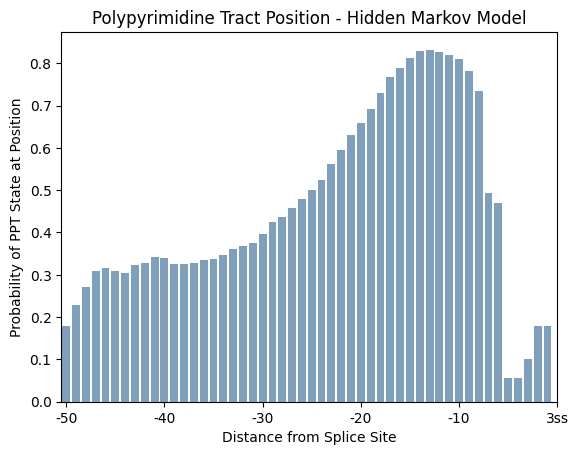

In [224]:
# HMM successfully identifies the polypyrimidine tract near the 3' splice site, dropping off by position -30, which agrees with prior literature.

sns.barplot([np.sum(np.where(received ==1)[1] == i)/len(received) for i in range(0,50)], color = 'steelblue', alpha = 0.75)
plt.title('Polypyrimidine Tract Position - Hidden Markov Model')
plt.xlabel('Distance from Splice Site')
plt.xticks(range(0,60,10), ['-50', '-40', '-30', '-20', '-10', '3ss'])
plt.ylabel('Probability of PPT State at Position')
plt.show()